In [3]:
import time
import os
import xarray as xr
from xeofs.single import ExtendedEOF
from dask.distributed import Client
import numpy as np

total_start = time.time()  # Start the total timer

# Initialize Dask client
start = time.time()
if 'client' not in globals():
    client = Client()
    print(f"Dask dashboard link: {client.dashboard_link}")
else:
    print("Dask client already exists. Skipping Dask client creation.")
print(f"Dask client setup time: {time.time() - start:.2f} seconds")

# Define file paths
input_path = "/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc"
# job_id = os.getenv('SLURM_JOB_ID', 'default_job_id')
# output_path = f"/cluster/home/haroldh/spGDMM/1_data/4_interim/EOFs/EEOF_basic_{job_id}.nc"

# Check if input file exists
if not os.path.exists(input_path):
    raise FileNotFoundError(f"Input file not found at: {input_path}")

# Load dataset and select variable
start = time.time()
try:
    # Open and preprocess the dataset
    ds = xr.open_dataset(input_path).isel(zc=0).drop_vars('zc')
    ds = ds[['temperature', 'salinity', 'u_velocity', 'v_velocity', 'elevation']]
    # ds = ds.isel(xc=slice(0, 50), yc=slice(0, 50), time=slice(0, 50))
    ds.attrs.clear()
    for var in ds.data_vars:
        ds[var].attrs.clear()
    data = ds.assign_coords(time=('time', range(ds.sizes['time'])))

    # Convert the dataset into a DataArray with a `variable` dimension
    combined = data.to_array(dim="variable")
    
    # Ensure the combined DataArray is ready for EOF analysis
    print("Combined DataArray dimensions:", combined.dims)
    print("Combined DataArray coordinates:", combined.coords)

except Exception as e:
    raise RuntimeError(f"Error loading, processing, or combining dataset: {e}")


# Perform Extended EOF analysis
start = time.time()
try:
    model = ExtendedEOF(
        n_modes=8,               # Number of modes to calculate
        tau=14,                  # Time delay between successive copies
        embedding=3,             # How many lagged dimensions to include
        n_pca_modes=50,          # How many PCA modes to retain (will run PCA before EEOF)
        center=True,             # Center the input data
        standardize=True,        # Standardize the data
        use_coslat=False,        # Do not apply cosine latitude weighting
        check_nans=True,         # Ignore NaNs in analysis
        solver='auto',           # Use the default solver
    )

    model.fit(combined, dim=['time'])
    print("Extended EOF analysis completed successfully.")
except Exception as e:
    raise RuntimeError(f"Error during Extended EOF analysis: {e}")
print(f"Extended EOF analysis time: {time.time() - start:.2f} seconds")

# # Save the result
# start = time.time()
# try:
#     os.makedirs(os.path.dirname(output_path), exist_ok=True)
#     model.save(output_path)
#     print(f"Results saved to: {output_path}")
# except Exception as e:
#     raise RuntimeError(f"Error saving results: {e}")
# print(f"Saving results time: {time.time() - start:.2f} seconds")

# Total time
print(f"Total execution time: {time.time() - total_start:.2f} seconds")


Dask client already exists. Skipping Dask client creation.
Dask client setup time: 0.00 seconds


Combined DataArray dimensions: ('variable', 'time', 'yc', 'xc')
Combined DataArray coordinates: Coordinates:
  * xc        (xc) float32 4kB 800.0 1.6e+03 2.4e+03 ... 7.592e+05 7.6e+05
  * yc        (yc) float32 2kB 800.0 1.6e+03 2.4e+03 ... 4.432e+05 4.44e+05
  * time      (time) int64 3kB 0 1 2 3 4 5 6 7 ... 358 359 360 361 362 363 364
  * variable  (variable) object 40B 'temperature' 'salinity' ... 'elevation'


/cluster/home/haroldh/.conda/envs/eof/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Extended EOF analysis completed successfully.
Extended EOF analysis time: 73.30 seconds
Total execution time: 352.51 seconds


In [4]:
model.save("/cluster/home/haroldh/spGDMM/1_data/4_interim/EOFs/EEOF_tsuve_50pca.nc", overwrite=True, engine='zarr')

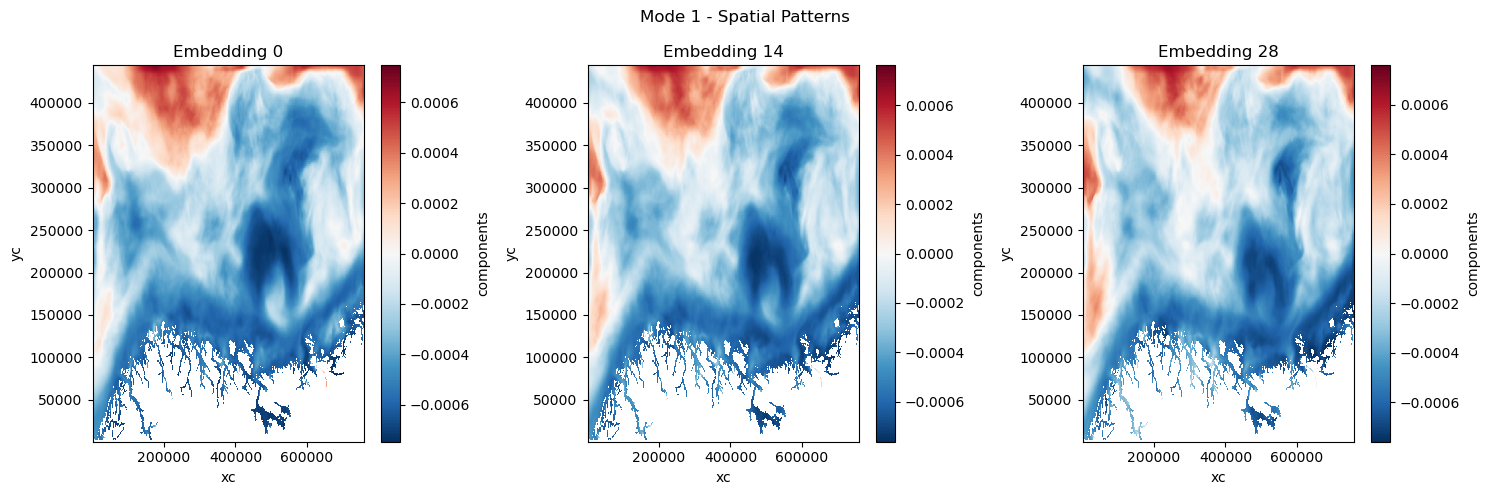

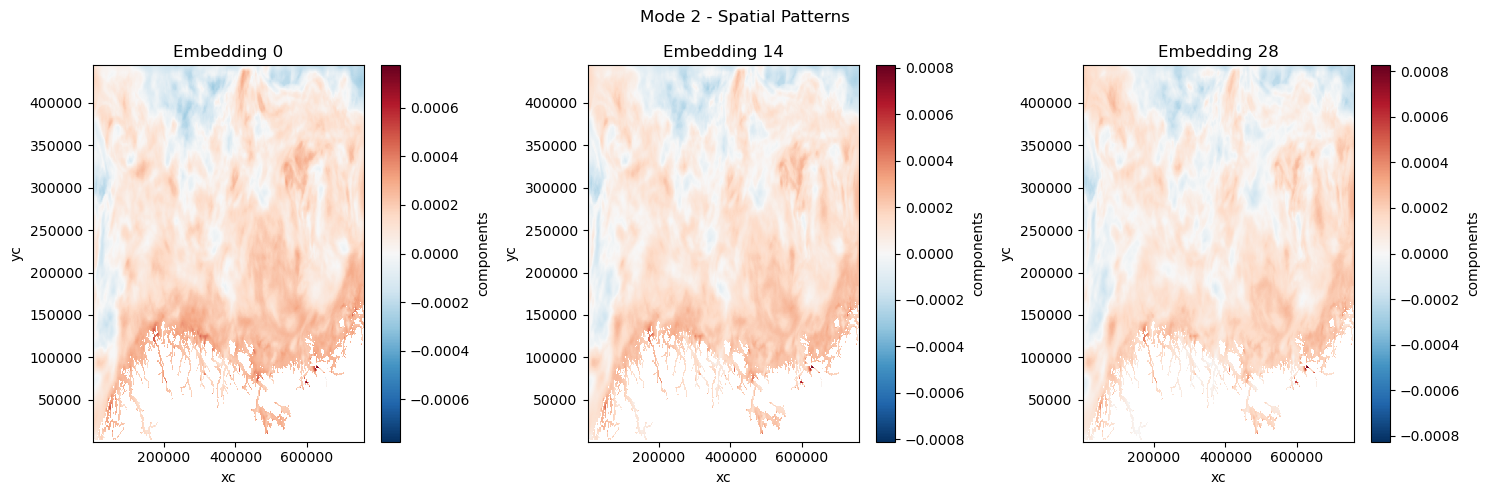

In [28]:
import matplotlib.pyplot as plt

# Access components: (feature, embedding, mode)
components = model.components()

# Iterate over modes and embeddings
n_modes = 2
for mode in range(n_modes):
    fig, axes = plt.subplots(1, components.sizes['embedding'], figsize=(15, 5))
    fig.suptitle(f"Mode {mode + 1} - Spatial Patterns")

    for i, emb in enumerate(components['embedding']):
        ax = axes[i]
        component = components.sel(mode=mode + 1, embedding=emb, variable='salinity')
        component.plot(ax=ax)
        ax.set_title(f"Embedding {emb.values}")

    plt.tight_layout()
    plt.show()


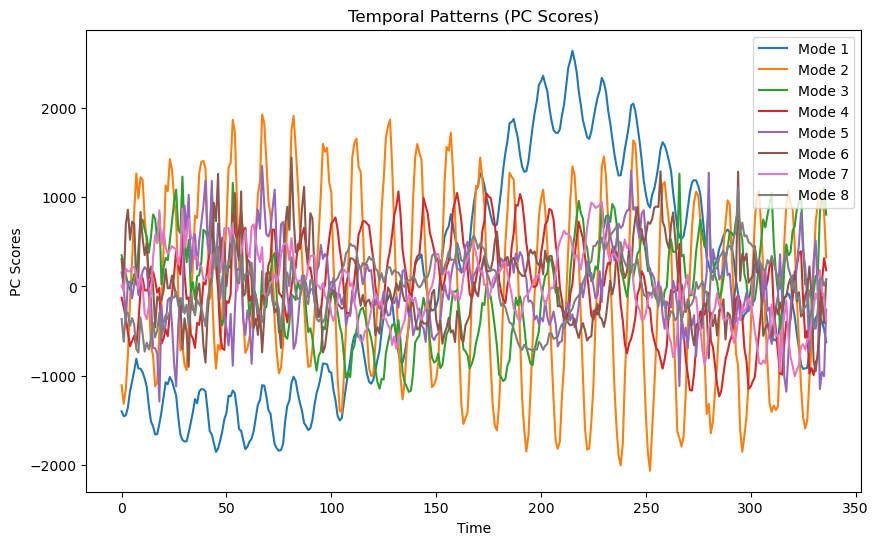

In [11]:
# Access scores: (time, mode)
scores = model.scores()

# Plot scores for the first few modes
n_modes = 8
plt.figure(figsize=(10, 6))
for mode in range(n_modes):
    plt.plot(scores['time'], scores.sel(mode=mode + 1), label=f"Mode {mode + 1}")

plt.xlabel("Time")
plt.ylabel("PC Scores")
plt.title("Temporal Patterns (PC Scores)")
plt.legend()
plt.show()


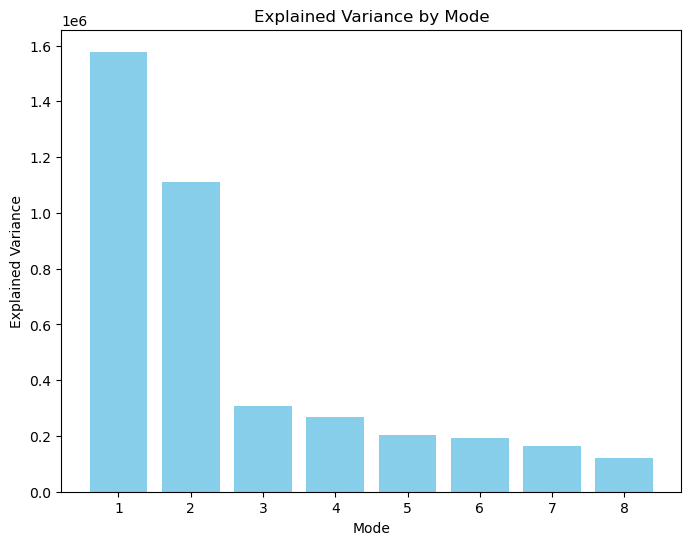

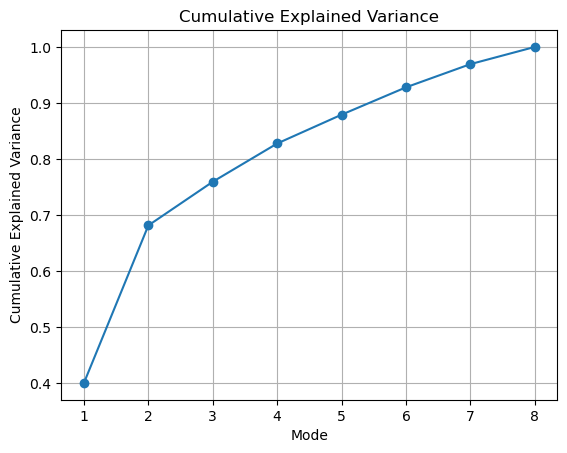

In [13]:
# Access explained variance
explained_variance = model.data['explained_variance']

# Plot explained variance
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance.values, color='skyblue')
plt.xlabel("Mode")
plt.ylabel("Explained Variance")
plt.title("Explained Variance by Mode")
plt.show()

cumulative_variance = explained_variance.cumsum() / explained_variance.sum()
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel("Mode")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance")
plt.grid()
plt.show()


In [19]:
model.components()

<xarray.DataArray 'components' (mode: 8, embedding: 3, variable: 5, yc: 555,
                                xc: 950)> Size: 506MB
array([[[[[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          ...,
          [ 2.46192861e-04,  2.46008459e-04,  2.45866651e-04, ...,
            2.12848062e-04,  2.12739911e-04,  2.13086851e-04],
          [ 2.46192861e-04,  2.46065613e-04,  2.46109315e-04, ...,
            2.13350008e-04,  2.13053655e-04,  2.13088553e-04],
          [ 2.46192861e-04,  2.46192861e-04,  2.46192861e-04, ...,
            2.13088553e-04,  2.13086851e-04,  2.13086851e-04]],

         [[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
...
          [ 1.07422305e-04,  1.12698628e-04,  1.22717211e-04, ...,
           -3.39930134e-04, -3.72621017e-04, -4.06083507e-04],
          [ 1.07422305e-04,  1.10333202e-04,  1.18539004e-04, ...,
           -3.66017467e-04, -3.75314625e-04, -4.07071918e-04],
          [ 1.07422305e-04,  1.07083509e-04,  1.07250932e-04, ...,
           -4.32193860e-04, -4.32193860e-04, -4.32193860e-04]],

         [[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          ...,
          [-6.59747202e-04, -6.42224496e-04, -6.24193671e-04, ...,
           -5.48281428e-04, -5.27599621e-04, -5.27882228e-04],
          [-6.59747202e-04, -6.24296769e-04, -6.13883444e-04, ...,
           -5.56809646e-04, -5.44845294e-04, -5.27882228e-04],
          [-6.59747202e-04, -6.01054446e-04, -6.01067963e-04, ...,
           -5.67014912e-04, -5.65652890e-04, -5.27882228e-04]]]]])
Coordinates:
  * variable   (variable) object 40B 'elevation' 'salinity' ... 'v_velocity'
  * yc         (yc) float32 2kB 800.0 1.6e+03 2.4e+03 ... 4.432e+05 4.44e+05
  * xc         (xc) float32 4kB 800.0 1.6e+03 2.4e+03 ... 7.592e+05 7.6e+05
  * embedding  (embedding) int64 24B 0 14 28
  * mode       (mode) int64 64B 1 2 3 4 5 6 7 8
Attributes: (12/15)
    model:          Extended EOF Analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-01-03 01:38:19
    n_modes:        8
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

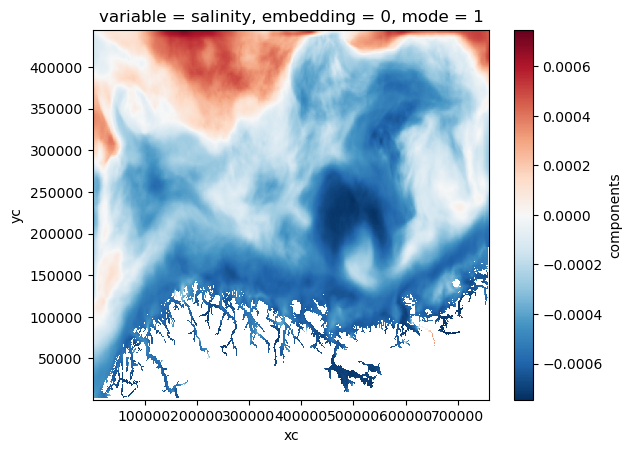

In [27]:
components = model.components()

component = components.isel(mode=0, embedding=0, variable=1)
component.plot()

In [16]:
model.scores()

<xarray.DataArray 'scores' (mode: 8, time: 365)> Size: 23kB
array([[-1397.90011155, -1452.80188157, -1442.42431667, ...,
                   nan,            nan,            nan],
       [-1106.68030128, -1312.45173464, -1153.0065888 , ...,
                   nan,            nan,            nan],
       [  348.99129511,   246.54445918,   142.78970147, ...,
                   nan,            nan,            nan],
       ...,
       [  306.69802282,     8.43284547,   694.3799321 , ...,
                   nan,            nan,            nan],
       [   11.54383845,   -56.34835936,   198.79458337, ...,
                   nan,            nan,            nan],
       [ -363.91332922,  -619.03899878,  -279.04703216, ...,
                   nan,            nan,            nan]])
Coordinates:
  * time     (time) int64 3kB 0 1 2 3 4 5 6 7 ... 358 359 360 361 362 363 364
  * mode     (mode) int64 64B 1 2 3 4 5 6 7 8
Attributes: (12/15)
    model:          Extended EOF Analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-01-03 01:38:19
    n_modes:        8
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

In [ ]:
# TRANSFORM THE DATA INTO THIS SPACE? Or just use these values...